# Transfer Learning
Use this notebook to run transfer learning on an individual subject. This assumes you have run `Create_General_Models.ipynb` already.

Nile Wilson, 2019.04.01

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import glob
import csv
import mne

## Set Variables

In [3]:
subjID = 'a1e6c0'
subject_group = 1
session_number = 1
EEGdevice = 8
isSVM = False

## Function Definitions
Functions to work with BCI files

In [4]:
def FindBCIFiles(subjID, run_number, session_number):
    """
    Returns the file names for the BCI run of choice
    """
    # Load latest model and its associated data
    BCI_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*' + subjID + '_BCI.easy')
    
    # Throw exception if model number is outside range of existing models
    if run_number-1 > len(BCI_files):
        raise ValueError('Please select a valid run number')
    
    filename_eeg = BCI_files[run_number-1]
    print('Selecting BCI EEG file: ' + filename_eeg)

    behavioral_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/BCI_' + subjID + '*.csv')
    filename_behavioral = behavioral_files[run_number-1]
    print('Selecting BCI behavioral file: ' + filename_behavioral)
    
    return filename_eeg, filename_behavioral

In [5]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [6]:
def LoadBehavioralDataBCI(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    
    return behavioralData

In [7]:
def SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]

        # Number of trials is greater than number of total pulses sent
        # 999 when the task ends
        move_left_starts = np.where(EEGdata['STI 014'] == 1)[0]
        move_right_starts = np.where(EEGdata['STI 014'] == 2)[0]
        rest_starts = np.where(EEGdata['STI 014'] == 3)[0]
        rest_ends = np.where(EEGdata['STI 014'] == 4)[0]
        
        # If the number of rest_starts and rest_ends don't match, drop the extra one
        # there should, by default, only be 12 starts and 12 ends

        if len(rest_ends) > len(rest_starts):
            if rest_ends[0] < rest_starts[0]:
                rest_ends = rest_ends[1:]
        elif len(rest_ends) < len(rest_starts):
            if rest_ends[0] > rest_starts[0]:
                rest_starts = rest_starts[1:]
        
        move_starts = np.sort(np.concatenate((move_left_starts,move_right_starts),0))
        total_movements = len(move_starts)

        # exclude movements that occur without defined baseline (if you need to get rid of first rest)
        hasBaseline = list()
        for movement in range(0,len(move_starts)):
            hasBaseline.append(True in (rest_starts < move_starts[movement]))

        np.where(hasBaseline)
        move_starts = move_starts[np.where(hasBaseline)]

        # exclude the move lefts and move rights that were thrown out in move_starts
        for movement in range(0,total_movements):
            if hasBaseline[movement] is False:
                # for the left movements
                idx_left = np.where(move_left_starts == move_starts[movement])
                idx_left = np.asarray(idx_left)
                idx_right = np.where(move_right_starts == move_starts[movement])
                idx_right = np.asarray(idx_right)

                if idx_left.size > 0:
                    move_left_starts = np.delete(move_left_starts, idx_left)
                if idx_right.size > 0:
                    move_right_starts = np.delete(move_right_starts, idx_right)
                
        num_of_trials = len(rest_starts)
        num_of_movements = len(move_left_starts) + len(move_right_starts)
    
    return num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends

In [8]:
def EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]

    epochs = []
    epochs_norm = []

    for movement in range(0,len(move_starts)):
        # Data for this movement
        t_start = move_starts[movement] - np.round(2.00*fs)
        t_end = move_starts[movement] - np.round(0.250*fs)

        # Baseline
        restOfInt = np.max(np.where(rest_starts < move_starts[movement]))
        tb_start = rest_starts[restOfInt]
        tb_end = rest_ends[restOfInt]

        # Note, baseline is filtered before it is used in the live script
        baseline_pre_filt = np.asarray(EEGdata.loc[tb_start:tb_end][channels]) * 1.0
        baseline_filt = filter_data(baseline_pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        baseline = baseline_filt.T

        # Filter per epoch, like you would in real-time
        pre_filt = np.asarray(EEGdata.loc[t_start:t_end][channels]) * 1.0
        filtered = filter_data(pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        epoch = pd.DataFrame(filtered.T)
        epoch.columns = EEGdata.columns[0:8]

        # Store epoch
        tmp = (epoch - np.mean(baseline,0))/np.std(baseline,0)
        tmp = pd.DataFrame(tmp)
        tmp.columns = EEGdata.columns[0:8]

        epochs_norm.append(tmp)
        epochs.append(epoch)

    return epochs, epochs_norm

In [9]:
def OrganizeTrials(behavioralData, hasBaseline):
    """
    Organizes trials
    """
    
    # When the target is to the left
    trialL = np.where(behavioralData['target_x'] < 1000)
    
    # When target was to the right
    trialR = np.where(behavioralData['target_x'] > 1000)
    
    # Create a single list that includes which movement is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1

    trial_type = np.round(trial_type[0])
    
    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline)):
        if hasBaseline[movement] is False:
            trial_type = np.delete(trial_type, movement)
            
    return trial_type

In [10]:
def ExtractFeaturesBCI(epochs, num_of_movements, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for movement in range(0, num_of_movements):
            f, Pxx_den = signal.welch(signal.decimate(epochs[movement][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) >= 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) >= 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

In [11]:
def LoadModel_MI(subjID, run_number=0, session_number=1, adaptationType='CS'):
    """
    This function loads the most recent motor imagery classifier
    for this subject by default. Current run minus 1.
    
    You may also select which number model (from original to most recent)
    by using a value from 0 (original) to 4 (most recent)
    """
    runOfInt = run_number
    run_number = runOfInt - 1
    # Load latest model and its associated data
    if runOfInt == 1:
        models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
        models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
    else:
        if adaptationType == 'CS' or adaptationType == 'None':
            models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
            models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
        elif adaptationType == 'TL':
            models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_TL_*')
            models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_TL_*')
    
    # Throw exception if model number is outside range of existing models
    if run_number > len(models):
        raise ValueError('Please select a valid model number')
    if adaptationType == 'TL':
        run_number = run_number -1
    model_file = models[run_number] # load the most recent model
    print('Selecting model: ' + model_file)
    clf = pickle.load(open(model_file, 'rb'))

    models_data = models_data_list[run_number] # load the most recent model
    MI_data = np.load(models_data)
    X_loaded = MI_data['X_not_scaled']
    y_loaded = MI_data['y']
    
    return clf, X_loaded, y_loaded

In [18]:
def LoadGeneralModel_MI(subjID, isSVM):
    """
    This function loads the most recent motor imagery classifier
    for this subject by default. Current run minus 1.
    
    You may also select which number model (from original to most recent)
    by using a value from 0 (original) to 4 (most recent)
    """
    
    if isSVM is True:
        model_file = 'Models/GeneralModels/excluding_' + subjID + '/General_Model_MI_excluding_' + subjID + '_SVM.sav' # load the most recent model
        models_data = 'Models/GeneralModels/excluding_' + subjID + '/Data_for_General_MI_classifier_excluding_' + subjID + '_SVM.npz' # load the most recent model
    else:
        model_file = 'Models/GeneralModels/excluding_' + subjID + '/General_Model_MI_excluding_' + subjID + '.sav' # load the most recent model
        models_data = 'Models/GeneralModels/excluding_' + subjID + '/Data_for_General_MI_classifier_excluding_' + subjID + '.npz' # load the most recent model
    
    print('Selecting model: ' + model_file)
    clf = pickle.load(open(model_file, 'rb'))
    
    MI_data = np.load(models_data)
    X_loaded = MI_data['X_not_scaled']
    y_loaded = MI_data['y']
    
    return clf, X_loaded, y_loaded

In [13]:
def GetBehavioralTL(runOfInt):
    # When the target is to the left
    trialL = np.where(behavioralData_all[runOfInt]['target_x'] < 1000)
    movementL = np.where(behavioralData_all[runOfInt]['direction_moved'] == 'left')

    # When target was to the right
    trialR = np.where(behavioralData_all[runOfInt]['target_x'] > 1000)
    movementR = np.where(behavioralData_all[runOfInt]['direction_moved'] == 'right')

    # Create a single list that includes which movement is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData_all[runOfInt]['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1
    trial_type = np.round(trial_type[0])

    direction_moved = np.zeros([1,len(behavioralData_all[runOfInt]['score'])])
    direction_moved[0][movementL] = 0
    direction_moved[0][movementR] = 1
    direction_moved = np.round(direction_moved[0])

    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline_all[runOfInt])):
        if hasBaseline_all[runOfInt][movement] is False:
            trial_type = np.delete(trial_type, movement)
            direction_moved = np.delete(direction_moved, movement)
    
    actual = direction_moved
    TL = trial_type
    return actual, TL

## Code to Run
Find BCI files

In [14]:
# Load latest model and its associated data
BCI_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*' + subjID + '_BCI.easy')
num_of_runs = len(BCI_files)

In [15]:
# Check that this is correct
print('Detected number of BCI runs: ' + str(num_of_runs))

Detected number of BCI runs: 5


### Simulate Performance
Load in the original model and the general model

In [20]:
orig_scores = list()
general_scores = list()
X_orig_all = dict()
y_orig_all = dict()
X_general_all = dict()
y_general_all = dict()
clf_orig_all = dict()
clf_general_all = dict()
behavioralData_all = dict()
hasBaseline_all = dict()
EEGdata_all = dict()

for runOfInt in range(1, num_of_runs+1):
    # Find BCI file names
    filename_eeg, filename_behavioral = FindBCIFiles(subjID, runOfInt, session_number)
    
    # Load EEG data
    EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)
    EEGdata_all[runOfInt] = EEGdata

    # Load behavioral data
    behavioralData = LoadBehavioralDataBCI(filename_behavioral)
    behavioralData_all[runOfInt] = behavioralData

    # Sync up trigger pulses
    num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends = SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData)
    hasBaseline_all[runOfInt] = hasBaseline
    
    # Epoch the data
    epochs, epochs_norm = EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends)

    # Organize trial types
    trial_type = OrganizeTrials(behavioralData, hasBaseline)

    # Get signal features
    alpha_power, beta_power = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)
    motor_features = [alpha_power['C3'], beta_power['C3'], alpha_power['C4'], beta_power['C4']]
    motor_features = np.transpose(motor_features)
    
    # Load a specific model (0 loads initial model trained on screening)
    # If using run_number, it will load the model created just prior to
    # this BCI run (simulated or created during the session)
    if subject_group == 1:
        clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, 1, session_number, 'None')
    elif subject_group == 2:
        clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, runOfInt, session_number, 'CS')
 
    # Get the original score
    X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
    y = trial_type
    orig_score = clf_orig.score(X, y)*100
    X_orig_all[runOfInt] = X
    y_orig_all[runOfInt] = y
    
    # Get the simulated score (using the general model)
    clf_general, X_loaded, y_loaded = LoadGeneralModel_MI(subjID, isSVM)
    
    X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
    y = trial_type
    general_score = clf_general.score(X, y)*100
    X_general_all[runOfInt] = X
    y_general_all[runOfInt] = y
    
    # Store values
    orig_scores.append(orig_score)
    general_scores.append(general_score)
    clf_orig_all[runOfInt] = clf_orig
    clf_general_all[runOfInt] = clf_general

Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319133926_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319134508_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319135043_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319135618_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319140149_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R5.csv
Skipping N/A
Selecting model: Models/a1e6c0/Session1\a1e6c0_MI_classifier_2019-03-19-13-38-32.sav
Selecting model: Models/GeneralModels/excluding_a1e6c0/General_Model_MI_excluding_a1e6c0.sav


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


## Simulate Performance

In [21]:
# Use behavioral data for original
actual_scores = list()
for runOfInt in range(1,5+1):
    actual, TL = GetBehavioralTL(runOfInt)
    correct_all = len(np.where(TL==actual)[0])/len(TL)*100
    actual_scores.append(correct_all)

In [37]:
# Get max and min for plotting
min_all = np.min([np.min(actual_scores),np.min(general_scores)])
max_all = np.max([np.max(actual_scores),np.max(general_scores)])

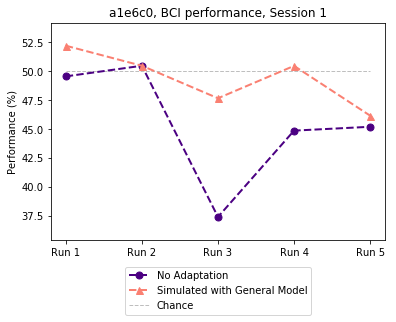

In [35]:
fig = plt.figure()
if subject_group == 1:
    
    plt.plot(actual_scores, color='indigo', marker='o', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.plot(general_scores, color='salmon', marker='^', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.xticks([0, 1, 2, 3, 4],['Run 1','Run 2','Run 3','Run 4','Run 5'])
    plt.ylabel('Performance (%)')
    plt.hlines(y=50, xmin=0, xmax=4, color='gray', linestyles='dashed',
               linewidth=1, alpha=0.5)
    plt.ylim([0, 100])
    plt.title(subjID + ', BCI performance, Session ' + str(session_number))
    lgd = plt.legend(['No Adaptation','Simulated with General Model','Chance'],
              loc='upper center', bbox_to_anchor=(0.5, -0.10))
    
elif subject_group == 2:
    plt.plot(actual_scores, color='indigo', marker='^', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.plot(general_scores, color='salmon', marker='P', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.xticks([0, 1, 2, 3, 4],['Run 1','Run 2','Run 3','Run 4','Run 5'])
    plt.ylabel('Performance (%)')
    plt.hlines(y=50, xmin=0, xmax=4, color='gray', linestyles='dashed',
               linewidth=1, alpha=0.5)
    plt.ylim([0, 100])
    plt.title(subjID + ', BCI performance, Session ' + str(session_number))
    lgd = plt.legend(['Co-Adaptation (CS)','Simulated with General Model','Chance'],
              loc='upper center', bbox_to_anchor=(0.5, -0.10))

plt.ylim([min_all-2, max_all+2])
plt.show()
fig.savefig('Figures/GeneralModels/excluding_' + subjID + '/' + subjID + '_Performance_Session-' + str(session_number) + '.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')

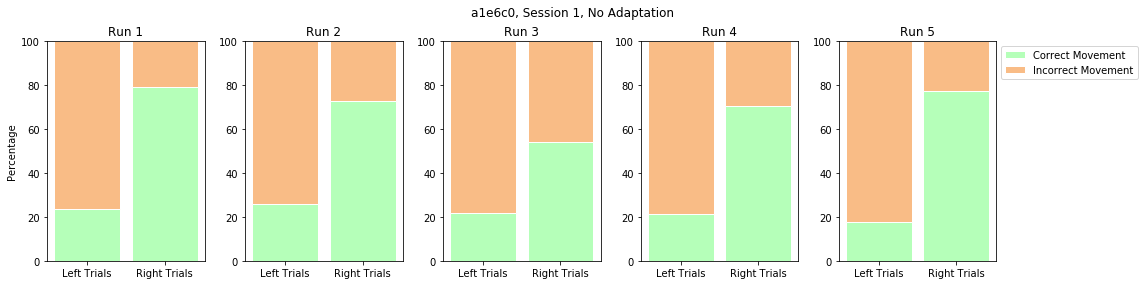

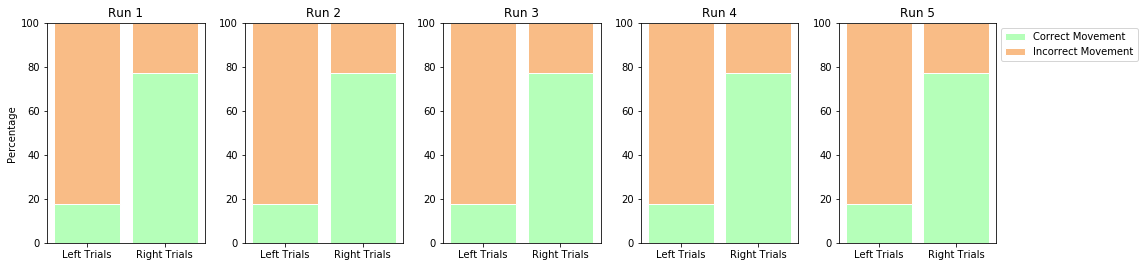

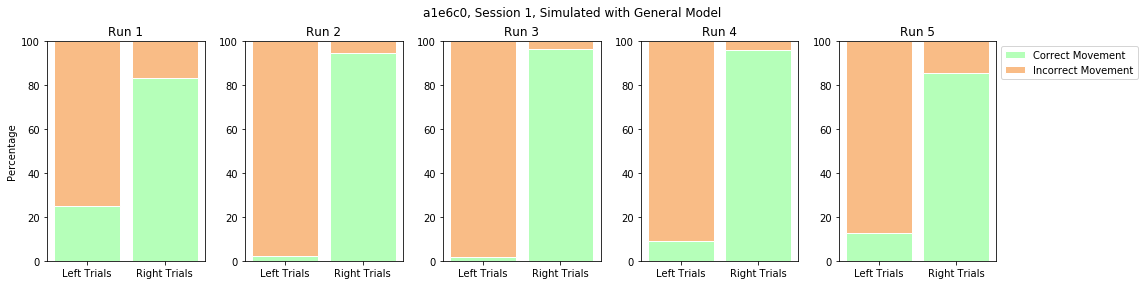

In [36]:
# Set adaptation type
adaptation_type = 'No Adaptation'

for adaptation_type in ['No Adaptation','Co-Adaptation','Simulated with General Model']:
    fig = plt.figure(figsize=(16,4))
    for runOfInt in range(1,5+1):
        # Calculate
        if subject_group == 1:
            if adaptation_type == 'No Adaptation':
                actual, TL = GetBehavioralTL(runOfInt)
            elif adaptation_type == 'Simulated with General Model':
                actual = clf_general_all[runOfInt].predict(X_general_all[runOfInt])
                TL = y_general_all[runOfInt] # true labels
        elif subject_group == 2:
            if adaptation_type == 'Co-Adaptation':
                actual, TL = GetBehavioralTL(runOfInt)
            elif adaptation_type == 'Simulated with General Model':
                actual = clf_general_all[runOfInt].predict(X_general_all[runOfInt])
                TL = y_general_all[runOfInt] # true labels
        trials_left = np.where(TL==0)[0]
        trials_right = np.where(TL==1)[0]
        left_correct = len(np.where(actual[trials_left]==0)[0])/len(actual[trials_left])*100
        left_wrong = 100 - left_correct
        right_correct = len(np.where(actual[trials_right]==1)[0])/len(actual[trials_right])*100
        right_wrong = 100 - right_correct

        # Organize data for bar plotting
        r = [0,1]
        raw_data = {'correctBars': [left_correct, right_correct], 'wrongBars': [left_wrong, right_wrong]}
        df = pd.DataFrame(raw_data)

        # From raw value to percentage
        correctBars = df['correctBars']
        wrongBars = df['wrongBars']

        # plot
        barWidth = 0.85
        names = ('Left Trials','Right Trials')
        plt.subplot(150+runOfInt)

        # Create green Bars
        plt.bar(r, correctBars, color='#b5ffb9', edgecolor='white', width=barWidth)
        # Create orange Bars
        plt.bar(r, wrongBars, bottom=correctBars, color='#f9bc86', edgecolor='white', width=barWidth)

        # Custom x axis
        plt.xticks(r, names)
        plt.ylim([0,100])
        if runOfInt == 1:
            plt.ylabel('Percentage')
        plt.title('Run ' + str(runOfInt))

    # Add a legend
    lgd = plt.legend(['Correct Movement','Incorrect Movement'], loc='upper left', bbox_to_anchor=(1,1), ncol=1)

    # Add super title
    if subject_group == 1:
        if adaptation_type == 'No Adaptation':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', No Adaptation')
        elif adaptation_type == 'Simulated with General Model':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', Simulated with General Model')
    elif subject_group == 2:
        if adaptation_type == 'Co-Adaptation':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', Co-Adaptation')
        elif adaptation_type == 'Simulated with General Model':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', Simulated with General Model')
    fig.tight_layout()
    fig.subplots_adjust(top=0.86)

    # Show graphic
    plt.show()
    fig.savefig('Figures/GeneralModels/excluding_' + subjID + '/' + subjID + '_LR_Session-' + str(session_number) + '_' + adaptation_type + '.png',
            bbox_extra_artists=(lgd,))

Look at an individual trial if you like

In [27]:
runOfInt = 5
print('Run ' + str(runOfInt) + ' (original)')
print('Total number of examples: ' + str(len(X_orig_all[runOfInt])))
print('Percent of expected control movements: '
      + str(clf_orig_all[runOfInt].score(
          X_orig_all[runOfInt], y_orig_all[runOfInt])*100) + '%')
print('----------------')
print('Confusion Matrix for MI')
print(confusion_matrix(y_orig_all[runOfInt], clf_orig_all[runOfInt].predict(
    X_orig_all[runOfInt])))
print('----------------')

Run 5 (original)
Total number of examples: 104
Percent of expected control movements: 50.0%
----------------
Confusion Matrix for MI
[[24 32]
 [20 28]]
----------------
